In [82]:
import numpy as np
from numpy.fft import fft
from scipy.signal.windows import hamming

def eeg_rpsd(EEG, nfreqs=None, pct_data=100):
    # clean input cutoff freq
    nyquist = EEG['srate'] // 2
    if nfreqs is None or nfreqs > nyquist:
        nfreqs = nyquist
    
    # setup constants
    ncomp = EEG['icaweights'].shape[0]
    
    # Hamming window
    n_points = min(EEG['pnts'], EEG['srate'])
    m = n_points
    isOddLength = m % 2
    if isOddLength:
        x = np.arange(0, (m - 1) / 2 + 1) / (m - 1)
    else:
        x = np.arange(0, m / 2) / (m - 1)
    
    a = 0.54
    window = a - (1 - a) * np.cos(2 * np.pi * x)
    if isOddLength:
        window = np.concatenate([window, window[-2::-1]])
    else:
        window = np.concatenate([window, window[::-1]])
    
    cutoff = (EEG['pnts'] // n_points) * n_points
    index = np.add.outer(np.arange(0, cutoff - n_points//2, n_points // 2), np.arange(0, n_points)).astype(int).transpose()
    
    np.random.seed(0)  # rng('default') in MATLAB
    n_seg = index.shape[1] * EEG['trials']
    subset = np.random.permutation(n_seg)[:int(n_seg * pct_data / 100)]
    
    # calculate windowed spectrums
    psdmed = np.zeros((ncomp, nfreqs))
    for it in range(ncomp):
        temp = np.reshape(EEG['icaact'][it, index, :], (1, index.shape[0], index.shape[1] * EEG['trials']))
        temp = temp[:, :, subset] * window[:, np.newaxis]
        temp = fft(temp, n_points, axis=1)
        temp = np.abs(temp) ** 2
        temp = temp[:, 1:nfreqs + 1, :] * 2 / (EEG['srate'] * np.sum(window ** 2))
        if nfreqs == nyquist:
            temp[:, -1, :] /= 2
        psdmed[it, :] = 20 * np.log10(np.median(temp, axis=2))
    
    return psdmed

def test_eeg_rpsd():
    EEG = {
        'srate': 256,
        'icaweights': np.random.randn(10, 256),
        'pnts': 1000,
        'trials': 5,
        'icaact': np.random.randn(10, 1000, 5)
    }
    
    psdmed = eeg_rpsd(EEG, 100)
    assert psdmed.shape == (10, 100)
    assert np.all(np.isfinite(psdmed))

# test_eeg_rpsd()
eeg_rpsd(EEG, 100)

array([[  0.75448972,   8.53363469,   7.41523286, ...,  -1.26850654,
         -2.04666631,  -9.37131422],
       [  2.46241342,  -1.86479778,   1.41678819, ..., -10.44787118,
        -12.40352459, -23.11403972],
       [ -1.85235722,  -5.46042076,  -2.42082689, ..., -19.6444734 ,
        -14.88046152, -22.87946595],
       ...,
       [-25.33912598, -30.41152803, -22.31337437, ..., -39.54646885,
        -37.93556211, -46.85885251],
       [-34.40785783, -32.61799752, -28.6838869 , ..., -40.78338579,
        -39.35519729, -46.13414687],
       [-38.1219461 , -29.37829777, -27.27699321, ..., -44.39603851,
        -41.79977468, -50.59062452]])

In [2]:
from oct2py import octave as eeglab

path2eeglab = '/System/Volumes/Data/data/matlab/eeglab/'
eeglab.addpath(path2eeglab + '/functions/guifunc');
eeglab.addpath(path2eeglab + '/functions/popfunc');
eeglab.addpath(path2eeglab + '/functions/adminfunc');
eeglab.addpath(path2eeglab + '/functions/sigprocfunc');
eeglab.addpath(path2eeglab + '/functions/miscfunc');
eeglab.addpath(path2eeglab + '/plugins/dipfit');

EEG = eeglab.pop_loadset(path2eeglab + '/sample_data/eeglab_data_epochs_ica.set');





















pop_loadset(): loading file /System/Volumes/Data/data/matlab/eeglab/sample_data/eeglab_data_epochs_ica.set ...
    eeg_checkset at line 187 column 1
    pop_loadset at line 249 column 9
    _pyeval at line 57 column 30

    eeg_hist at line 53 column 21
    eeg_checkset at line 1277 column 13
    pop_loadset at line 249 column 9
    _pyeval at line 57 column 30

    eeg_checkset at line 187 column 1
    pop_loadset at line 253 column 13
    _pyeval at line 57 column 30

Reading float file '/System/Volumes/Data/data/matlab/eeglab/sample_data/eeglab_data_epochs_ica.fdt'...
Scaling components to RMS microvolt
eeg_checkset: recomputing the ICA activation matrix ...


In [6]:
import pop_loadset
import importlib
import matplotlib.pyplot as plt
importlib.reload(pop_loadset)  # Step 3: Reload the library to reflect the changes
from pop_loadset import pop_loadset

print(EEG['data'][0,2,1])

eeglab_file_path = '/System/Volumes/Data/data/matlab/eeglab/sample_data/eeglab_data_epochs_ica.set'
eeglab_file_path = 'NDARZZ830JM7_eyesclosed.set'
EEG2 = pop_loadset(eeglab_file_path)

print(EEG2['data'][0,2,1])

# eeglab.eeg_compare(EEG, EEG2)

# print(EEG['filepath'])
# print(EEG2['filepath'])

# Field filepath differs
# Field icaact differs
# Field icawinv differs
# Field icaweights differs
# Field chanlocs differs
# Field urchanlocs differs
# Field chaninfo differs
# Field event differs (n=157 vs n=157)
# Field urevent differs
# Field epoch differs
# Field epochdescription differs
# Field reject differs
# Field history differs
# Field saved differs
# Field etc differs
# Field run missing in second dataset
# Field roi missing in second dataset
# The field above are different between the two datasets
# print them all
# print(EEG.keys())
# print(EEG2.keys())
# for key in EEG.keys():
#     if key in EEG2.keys():
#         if not np.all(EEG[key] == EEG2[key]):
#             print(key)
#     else:
#         print(key)
# for key in EEG2.keys():
#     if key not in EEG.keys():
#         print(key)
print(EEG['filepath'])
print(EEG2['filepath'])
print(EEG['icaact'].shape)
print(EEG2['icaact'].shape)
print(EEG['icawinv'].shape)
print(EEG2['icawinv'].shape)
print(EEG['icaweights'].shape)
print(EEG2['icaweights'].shape)
print(EEG['chanlocs'].shape)
print(EEG2['chanlocs'].shape)
print(EEG['urchanlocs'].shape)
print(EEG2['urchanlocs'].shape)

EEG['chanlocs']['labels'][0,0]

EEG.event.type[0,0]
EEG['event']['type'][0,0]
EEG2['event'][0]['type']

ImportError: module pop_loadset not in sys.modules

In [22]:
EEG2['event']

array([{'type': 'square', 'position': 2, 'latency': 129, 'urevent': 1, 'epoch': 1},
       {'type': 'square', 'position': 2, 'latency': 217.99999999999997, 'urevent': 2, 'epoch': 1},
       {'type': 'rt', 'position': 2, 'latency': 267.5393862500059, 'urevent': 3, 'epoch': 1},
       {'type': 'square', 'position': 2, 'latency': 424, 'urevent': 1, 'epoch': 2},
       {'type': 'square', 'position': 2, 'latency': 513, 'urevent': 2, 'epoch': 2},
       {'type': 'rt', 'position': 2, 'latency': 562.5393862500059, 'urevent': 3, 'epoch': 2},
       {'type': 'square', 'position': 2, 'latency': 897, 'urevent': 4, 'epoch': 3},
       {'type': 'rt', 'position': 2, 'latency': 953.9638937499985, 'urevent': 5, 'epoch': 3},
       {'type': 'square', 'position': 2, 'latency': 1281, 'urevent': 6, 'epoch': 4},
       {'type': 'square', 'position': 2, 'latency': 1665, 'urevent': 7, 'epoch': 5},
       {'type': 'rt', 'position': 2, 'latency': 1739.8851187499968, 'urevent': 8, 'epoch': 5},
       {'type': 's

In [37]:
import numpy as np

# Define the data type for the structured array
dtype = np.dtype([('name', 'S10'), ('age', 'i4'), ('height', 'f4')])

# Create a structured array
data = np.array([('Alice', 25, 5.5), ('Bob', 30, 6.0)], dtype=dtype)

# Accessing fields
print(data['name'])  # Output: [b'Alice' b'Bob']
print(data['age'])   # Output: [25 30]
print(data['height'])  # Output: [5.5 6.0]
data

[b'Alice' b'Bob']
[25 30]
[5.5 6. ]


array([(b'Alice', 25, 5.5), (b'Bob', 30, 6. )],
      dtype=[('name', 'S10'), ('age', '<i4'), ('height', '<f4')])

Creating RawArray with float64 data, n_channels=32, n_times=30720
    Range : 0 ... 30719 =      0.000 ...   239.992 secs
Ready.


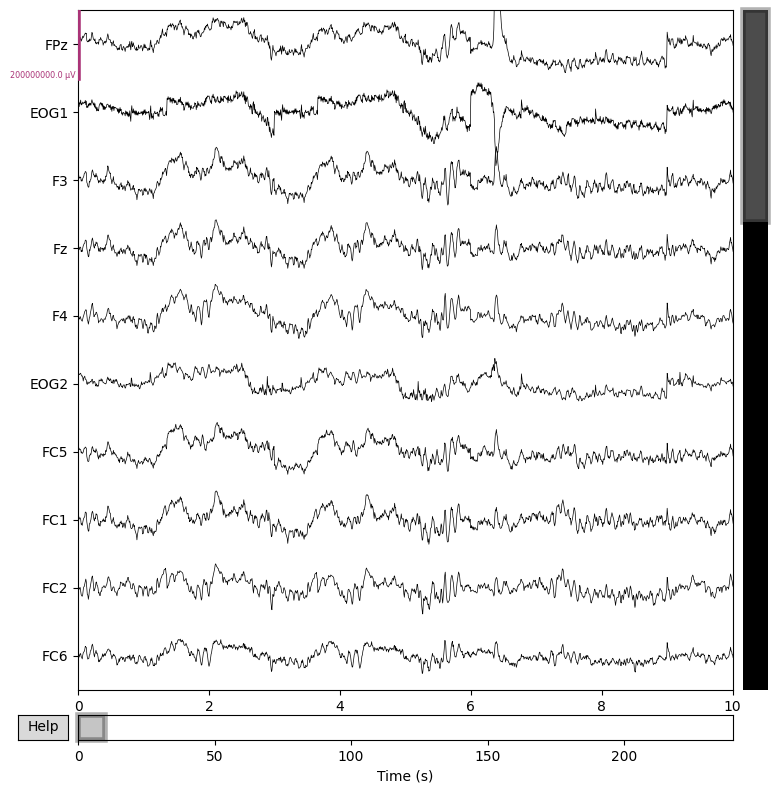

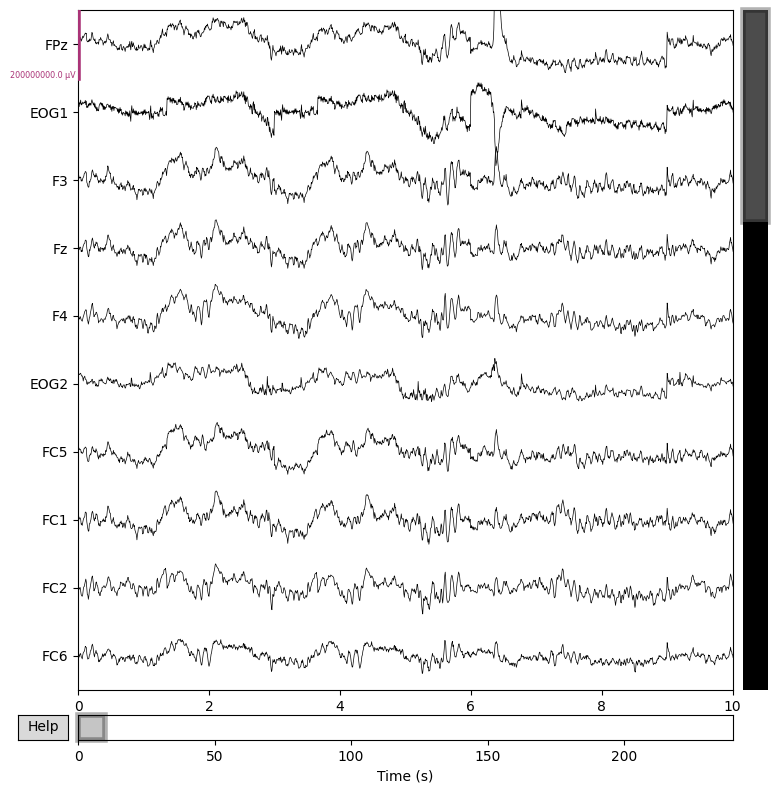

In [175]:
from topoplot import topoplot
from pop_loadset import pop_loadset
import os

eeglab_file_path = '/System/Volumes/Data/data/matlab/eeglab/sample_data/eeglab_data_epochs_ica.set'
EEG = pop_loadset(eeglab_file_path)

# plot data using MNE

import mne
import matplotlib.pyplot as plt

# create MNE info structure
info = mne.create_info(ch_names=[ x['labels'] for x in EEG['chanlocs']], sfreq=EEG['srate'], ch_types='eeg')

# create MNE Raw object
raw = mne.io.RawArray(EEG['data'].transpose(0,2,1).reshape(EEG['nbchan'], -1), info)

# plot data
raw.plot(n_channels=10, scalings=100, title='Data from arrays', show=True, block=True, duration=10.0)    

# plot topoplot
# topoplot(EEG['icawinv'][:, 0], EEG['chanlocs'], show=True)

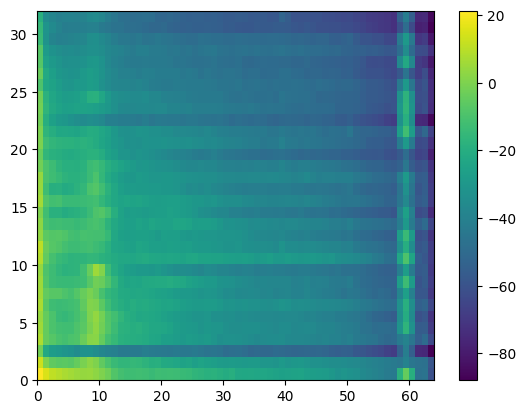

In [173]:
import pop_loadset
import importlib
import matplotlib.pyplot as plt
importlib.reload(pop_loadset)  # Step 3: Reload the library to reflect the changes
from pop_loadset import pop_loadset

EEG = pop_loadset(eeglab_file_path)
EEG['data']

nfreqs = 100
pct_data = 100

# clean input cutoff freq
nyquist = EEG['srate'] // 2
if nfreqs is None or nfreqs > nyquist:
    nfreqs = nyquist

# setup constants
ncomp = EEG['icaweights'].shape[0]

# Hamming window
n_points = min(EEG['pnts'], EEG['srate'])
m = n_points
isOddLength = m % 2
if isOddLength:
    x = np.arange(0, (m - 1) / 2 + 1) / (m - 1)
else:
    x = np.arange(0, m / 2) / (m - 1)

a = 0.54
window = a - (1 - a) * np.cos(2 * np.pi * x)
if isOddLength:
    window = np.concatenate([window, window[-2::-1]])
else:
    window = np.concatenate([window, window[::-1]])

cutoff = (EEG['pnts'] // n_points) * n_points
index = np.add.outer(np.arange(0, cutoff - n_points//2, n_points // 2), np.arange(0, n_points)).astype(int).transpose()

np.random.seed(42)  # rng('default') in MATLAB
n_seg = index.shape[1] * EEG['trials']
num_vals = int(n_seg * pct_data / 100)
subset = np.arange(0, num_vals)
random_numbers = np.random.rand(num_vals)
sort_idx = np.argsort(random_numbers)
subset = subset[sort_idx]

# subset = np.random.permutation(n_seg)[:int(n_seg * pct_data / 100)]

# calculate windowed spectrums
psdmed = np.zeros((ncomp, nfreqs))
for it in range(ncomp):
    temp = np.reshape(EEG['icaact'][it, index, :], (1, index.shape[0], index.shape[1] * EEG['trials']))
    temp = temp[:, :, subset] * window[:, np.newaxis]
    temp = fft(temp, n_points, axis=1)
    temp = np.abs(temp) ** 2
    temp = temp[:, 1:nfreqs + 1, :] * 2 / (EEG['srate'] * np.sum(window ** 2))
    if nfreqs == nyquist:
        temp[:, -1, :] /= 2
    psdmed[it, :] = 20 * np.log10(np.median(temp, axis=2))

# image psdmed
plt.imshow(psdmed, aspect='auto', origin='lower', extent=[0, nfreqs, 0, ncomp])
plt.colorbar()
plt.show()

In [171]:
import pop_loadset
importlib.reload(pop_loadset)  # Step 3: Reload the library to reflect the changes
from pop_loadset import pop_loadset
eeglab_file_path = '/System/Volumes/Data/data/matlab/eeglab/sample_data/eeglab_data_epochs_ica.set'
EEG = pop_loadset(eeglab_file_path)
# EEG['data'].transpose(2, 0, 1).shape
# EEG['data'][:2,:2,:2]
EEG['data'][5,10,11]
# EEG['data'][:,1,0]

-7.679533

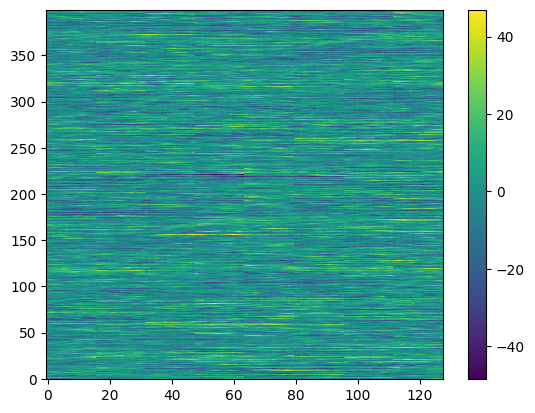

In [107]:
plt.imshow(temp[:,:].squeeze(), aspect='auto', origin='lower', interpolation='none')
plt.colorbar()
plt.show()


In [115]:
import numpy as np

# Set the seed for reproducibility
np.random.seed(42)

# Generate random numbers and use them to shuffle the array
array = np.arange(1, 11)  # Create an array [1, 2, ..., 10]
random_numbers = np.random.rand(len(array))
sort_idx = np.argsort(random_numbers)
shuffled_array = array[sort_idx]

print(shuffled_array)

[ 7  6  5  1  4  9 10  3  8  2]


In [96]:
temp.squeeze().shape

(128, 400)

In [17]:
import pop_loadset
import importlib
importlib.reload(pop_loadset)  # Step 3: Reload the library to reflect the changes
from pop_loadset import pop_loadset

var = pop_loadset('var.mat')
var['test'][2]